This notebook includes a first sketch of the ShorelineNet implementation in pytorch. 

In particular I want to achieve the following: 
* config loading
* network saving & loading
* try to wrap everything in classes
* where possible, use type annotations
* experiment with MC dropout & posterior estimation

15 Jan: loaded images

16 Jan: augmentation pipeline

17 Jan: Create network architecture & load pre-trained encoder

18 Jan: Set up loss function & training loop

In [25]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
import os

from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
from skimage import transform, io
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torch import ones_like, zeros_like
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
# load MaSTr dataset
mastr_path = '../../project_offline/Dataset/MaSTr1325/'

data_transforms = {
    'shared': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        # transforms.Normalize(0, 1),
    ]), 
    'mask': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        # transforms.Normalize(0, 1),
    ])
}


In [27]:
class MastrDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.mask_dir = mask_dir
        self.img_dir = img_dir
        self.transform = transform

        self.img_file_names = os.listdir(img_dir)

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_file_names[idx])
        mask_path = os.path.join(
            self.mask_dir, self.img_file_names[idx].replace(".jpg", "m.png"))

        image = io.imread(img_path)
        mask = io.imread(mask_path)

        # NOTE: image format: (C, W, H)

        # 
        sample = {'image': image, 'mask': mask}
        if self.transform:
            sample = self.transform(sample)
        
        return sample



In [28]:
class ImageDisplayer():
    def __init__(self, images, labels, predictions=None):
        self.images = images
        self.labels = labels
        self.predictions = predictions

    def show_sample(self, idx=None):
        if idx is None:
            idx = np.random.randint(0, len(self.images))
        if len(self.images.shape) == 3:
            self.images = self.images.unsqueeze(0)
            self.labels = self.labels.unsqueeze(0)

        img = self.images[idx].permute(1, 2, 0)
        labels = self.labels[idx].permute(1, 2, 0)

        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.title('Input Image')
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('True Mask')
        plt.imshow(labels)
        plt.axis('off')

        plt.tight_layout()



In [29]:
# Flip, Hue & sat, Rotation, Scaling, Resize, Normalize

# Only on tensors!
class HFlip(object):
    def __init__(self, prob):
        self.prob = prob
        self.HFlip = transforms.RandomHorizontalFlip(1)

    def __call__(self, data):
        image, mask = data['image'], data['mask']
        p = random.random()
        if p < self.prob:
            image = self.HFlip(image)
            mask = self.HFlip(mask)

        return {'image': image, 'mask': mask}



class HueSatCon(object):
    def __init__(self, brightness, contrast, saturation, hue, prob):
        self.prob = prob
        self.hue_transform = torchvision.transforms.ColorJitter(
            brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)

    def __call__(self, data):
        image, mask = data['image'], data['mask']
        p = random.random()
        if p < self.prob:
            image = self.hue_transform(image)
        return {'image': image, 'mask': mask}


class Rotation(object):
    def __init__(self, angle, prob=1):
        self.prob = prob
        self.angle = angle

    def __call__(self, data):
        image, mask = data['image'], data['mask']
        rot_angle = (random.random()*2-1) * self.angle
        p = random.random()
        if p < self.prob:
            image = TF.rotate(image, rot_angle, expand=True)
            mask = TF.rotate(mask, rot_angle,  expand=True)
        return {'image': image, 'mask': mask}

class Crop(object):
    def __init__(self, crop_percentage):
        self.crop_percentage = crop_percentage
    
    def __call__(self, data):
        image, mask = data['image'], data['mask']
        img_dim = image.shape[1]
        height = int(self.crop_percentage * img_dim)
        width = int(self.crop_percentage * img_dim)
        left = int(random.random() * ((1-self.crop_percentage)/2) * img_dim)
        top = int(random.random() * ((1-self.crop_percentage)/2) * img_dim)

        image = TF.crop(image, top, left, height, width)
        mask = TF.crop(mask, top, left, height, width)

        return {'image': image, 'mask': mask}

# class Resize(object):
#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         self.output_size = output_size

#     def __call__(self, data):
#         image, mask = data['image'], data['mask']
#         h, w = image.shape[:2]
#         if isinstance(self.output_size, int):
#             if h > w:
#                 new_h, new_w = self.output_size * h / w, self.output_size
#             else:
#                 new_h, new_w = self.output_size, self.output_size * w / h
#         else:
#             new_h, new_w = self.output_size

#         new_h, new_w = int(new_h), int(new_w)

#         image = transform.resize(image, (new_h, new_w))
#         mask = transform.resize(mask, (new_h, new_w))

#         return {'image': image, 'mask': mask}

class Resize(object):
    def __init__(self, size):
        self.size = size
        self.resize = torchvision.transforms.Resize(size)

    def __call__(self, data):
        image, mask = data['image'], data['mask']
        image = self.resize(image)
        mask = self.resize(mask)

        return {'image': image, 'mask': mask}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, data):
        image, mask = data['image'], data['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image).to(dtype=torch.float32) / 255
        mask = torch.from_numpy(mask).unsqueeze(0).to(dtype=torch.float32)
        mask = torch.where(mask == 4, ones_like(mask)*3, mask)
        return {'image': image, 'mask': mask}

# class Normalize(object):
#     def __call__(self, data):
#         image, mask = data['image'], data['mask']


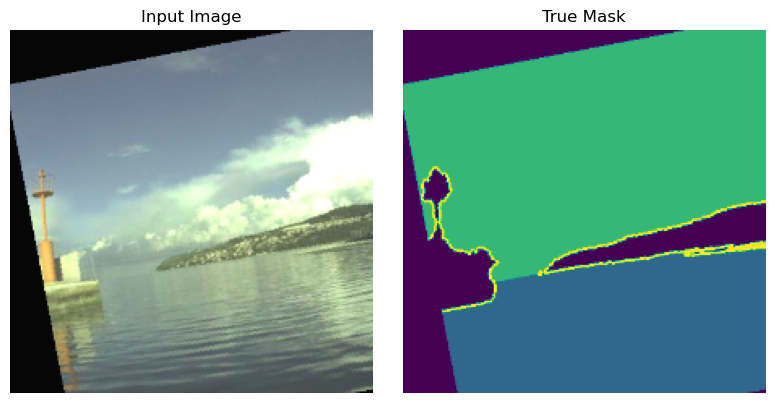

In [13]:
custom_transforms = transforms.Compose([
    ToTensor(),
    HFlip(prob=0.5),
    Rotation(15, prob=1),
    HueSatCon(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, prob=1),
    Crop(0.8),
    Resize((224, 224)),
]
)
dataset = MastrDataset(os.path.join(mastr_path, 'images'),
                       os.path.join(mastr_path, 'masks'),
                       custom_transforms)

train_dataloader = DataLoader(dataset, batch_size=20, shuffle=True)

sample = next(iter(train_dataloader))

imgs, labels = sample['image'], sample['mask']
img_displayer = ImageDisplayer(imgs, labels)
img_displayer.show_sample(idx=0)


### Encoder definition

In [125]:
mobileNetWeights = torchvision.models.MobileNet_V2_Weights
mobileNet = torchvision.models.mobilenet_v2(weights=mobileNetWeights)

mobileNet.features[-1] = nn.Identity()
mobileNet.classifier = nn.Identity()

# print(mobileNet)


In [ ]:
# summary(mobileNet, (3, 224, 224))

In [236]:
class Encoder_feature_extractor():
    def __init__(self, encoder):
        self.features = {}
        
        layers = {
            "skip_1": encoder.features[2].conv[0][2], 
            "skip_2": encoder.features[4].conv[0][2],
            "skip_3": encoder.features[7].conv[0][2],
            "skip_4": encoder.features[14].conv[0][2],
            "skip_5": encoder.features[17]
        }

        for (name, layer) in layers.items():
            layer.register_forward_hook(self._get_feature(name))
    
    def _get_feature(self, name):
        def hook(model, input, output):
            self.features[name] = output
        return hook


# if we extract based on blocks this is what we'd get instead:
# layers = {
#     "block_1": mobileNet.features[1], 
#     "block_2": mobileNet.features[3],
#     "block_3": mobileNet.features[6],
#     "block_4": mobileNet.features[13],
#     "block_5": mobileNet.features[17]
# }

feature_extractor = Encoder_feature_extractor(mobileNet)

# dummy forward pass
dummy_input = torch.rand((2, 3, 224, 224))

out = mobileNet(dummy_input)

print(out.shape)

for (key, value) in feature_extractor.features.items():
    print(f'{key}: {value.shape}')

torch.Size([2, 320])
skip_1: torch.Size([2, 96, 112, 112])
skip_2: torch.Size([2, 144, 56, 56])
skip_3: torch.Size([2, 192, 28, 28])
skip_4: torch.Size([2, 576, 14, 14])
skip_5: torch.Size([2, 320, 7, 7])


### Decoder Definition

In [237]:
# Conv2DTranspose => Batchnorm => Dropout => Relu
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.loaded = False
        
    def load(self, encoder_features):
        deconv_outputs = [512, 256, 128, 64, 3]
        # print(encoder_features.features)

        in_channels = encoder_features.features['skip_5'].shape[1]

        self.block_1 = self.deconv_block(in_channels, deconv_outputs[0], 3, 2)
        in_channels = deconv_outputs[0] + encoder_features.features['skip_4'].shape[1]

        self.block_2 = self.deconv_block(in_channels, deconv_outputs[1], 3, 2)
        in_channels = deconv_outputs[1] + encoder_features.features['skip_3'].shape[1]

        self.block_3 = self.deconv_block(in_channels, deconv_outputs[2], 3, 2)
        in_channels = deconv_outputs[2] + encoder_features.features['skip_2'].shape[1]

        self.block_4 = self.deconv_block(in_channels, deconv_outputs[3], 3, 2)
        in_channels = deconv_outputs[3] + encoder_features.features['skip_1'].shape[1]

        self.block_5 = self.deconv_block(in_channels, deconv_outputs[4], 3, 2)

        self.loaded = True

    def deconv_block(self, in_channels, out_channels, kernel_size, stride, dropout=0.5):
        conv_transpose_2d = nn.ConvTranspose2d(
                in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=1, output_padding=1)
        torch.nn.init.xavier_normal_(conv_transpose_2d.weight)
        return nn.Sequential(
            conv_transpose_2d,
            nn.BatchNorm2d(num_features=out_channels),
            nn.Dropout(p=dropout),
            nn.ReLU()
        )

    def forward(self, input):
        
        assert(self.loaded==True)

        x = input['skip_5']
        x = self.block_1(x)
        x = torch.cat((x, input['skip_4']), dim=1)
        x = self.block_2(x)
        x = torch.cat((x, input['skip_3']), dim=1)
        x = self.block_3(x)
        x = torch.cat((x, input['skip_2']), dim=1)
        x = self.block_4(x)
        x = torch.cat((x, input['skip_1']), dim=1)
        x = self.block_5(x)

        return x

### UNET definition

In [238]:
class Unet(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        # attaches hooks to the encoder
        self.feature_extractor = Encoder_feature_extractor(self.encoder)
        # dummy forward pass
        dummy_input = torch.rand((2, 3, 224, 224))
        mobileNet(dummy_input)
        
        self.decoder.load(self.feature_extractor)

    def forward(self, x):
        self.encoder(x)
        out = self.decoder(self.feature_extractor.features)
        return out

encoder = mobileNet
decoder = Decoder()
unet = Unet(encoder, decoder)

# out = unet(dummy_input)


unet

Unet(
  (encoder): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), s

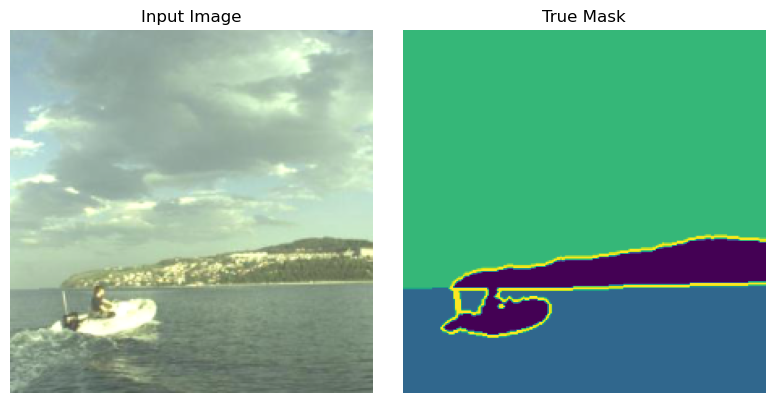

In [239]:
img_displayer.show_sample(1)

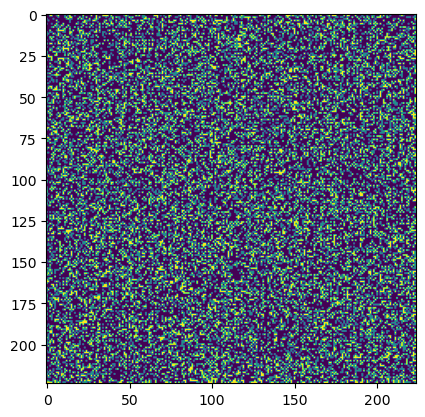

In [240]:
plt.imshow(torch.argmax(unet(imgs[1:2])[0], dim=0).detach().numpy())

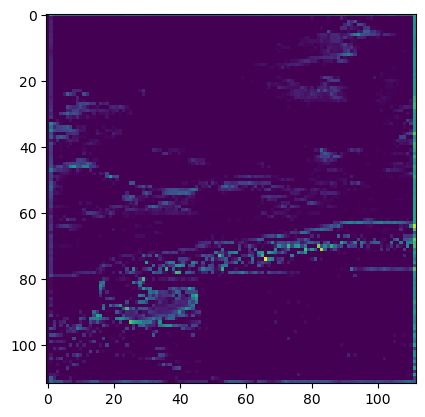

In [254]:
# plt.imshow(feature_extractor.features['skip_1'][0][16].detach().numpy())